### Loading GNM output

In [1]:
#################################################################### Loading packages ####################################################################
%matplotlib inline
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
from scipy.spatial import distance_matrix
from Censored_copula import truncgauss
import math 
#################################################################### Loading GNM ####################################################################
model_version = 5 # Data before Nov4 -> 7, Data at Nov4 -> 5
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')
import glms
import pickle
import torch
path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
print([path_,ckpt_path])
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

GNM_output = pickle.load( open(os.path.join(path_,"test_output_2014_2019-07.pkl"),"rb") )
location_keys = list(GNM_output.keys())                 # 'lat_58.95_57.35_lon_-6.55_-4.95', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'

#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [float(location_key.split('_')[i]) for i in [1,2,4,5]]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][0][row][column]

location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = [GNM_output[location_keys[100]]['date'][0]+np.timedelta64(i, 'D') for i in range(2002)]
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
                continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]])
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([round(temp_lat_lon[0]-0.6-row*0.1,2),round(temp_lat_lon[2]+0.6+col*0.1,2)])
            for param_idx,param in enumerate(output_keys[:-1]):
                for week in range(286):
                    for day in range(7):
                        GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][week][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(4087)]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))
#################################################################### Preparing map ####################################################################
m = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3)
            
m_loc_4087 = [[0,1] for i in range(len(GNM_landonly))]
for i in range(len(GNM_landonly)):
    m_loc_4087[i][0] = m(3,GNM_landonly[i][5][0])[1]
    m_loc_4087[i][1] = m(GNM_landonly[i][5][1],3)[0]
  

c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_5/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_5/checkpoints/epoch=11-step=9147-val_loss_loss=-0.391-val_metric_mse_rain=21.686.ckpt']


100%|██████████| 344/344 [00:23<00:00, 14.74it/s]


### Plotting map vs observed

211


2it [00:03,  1.91s/it]


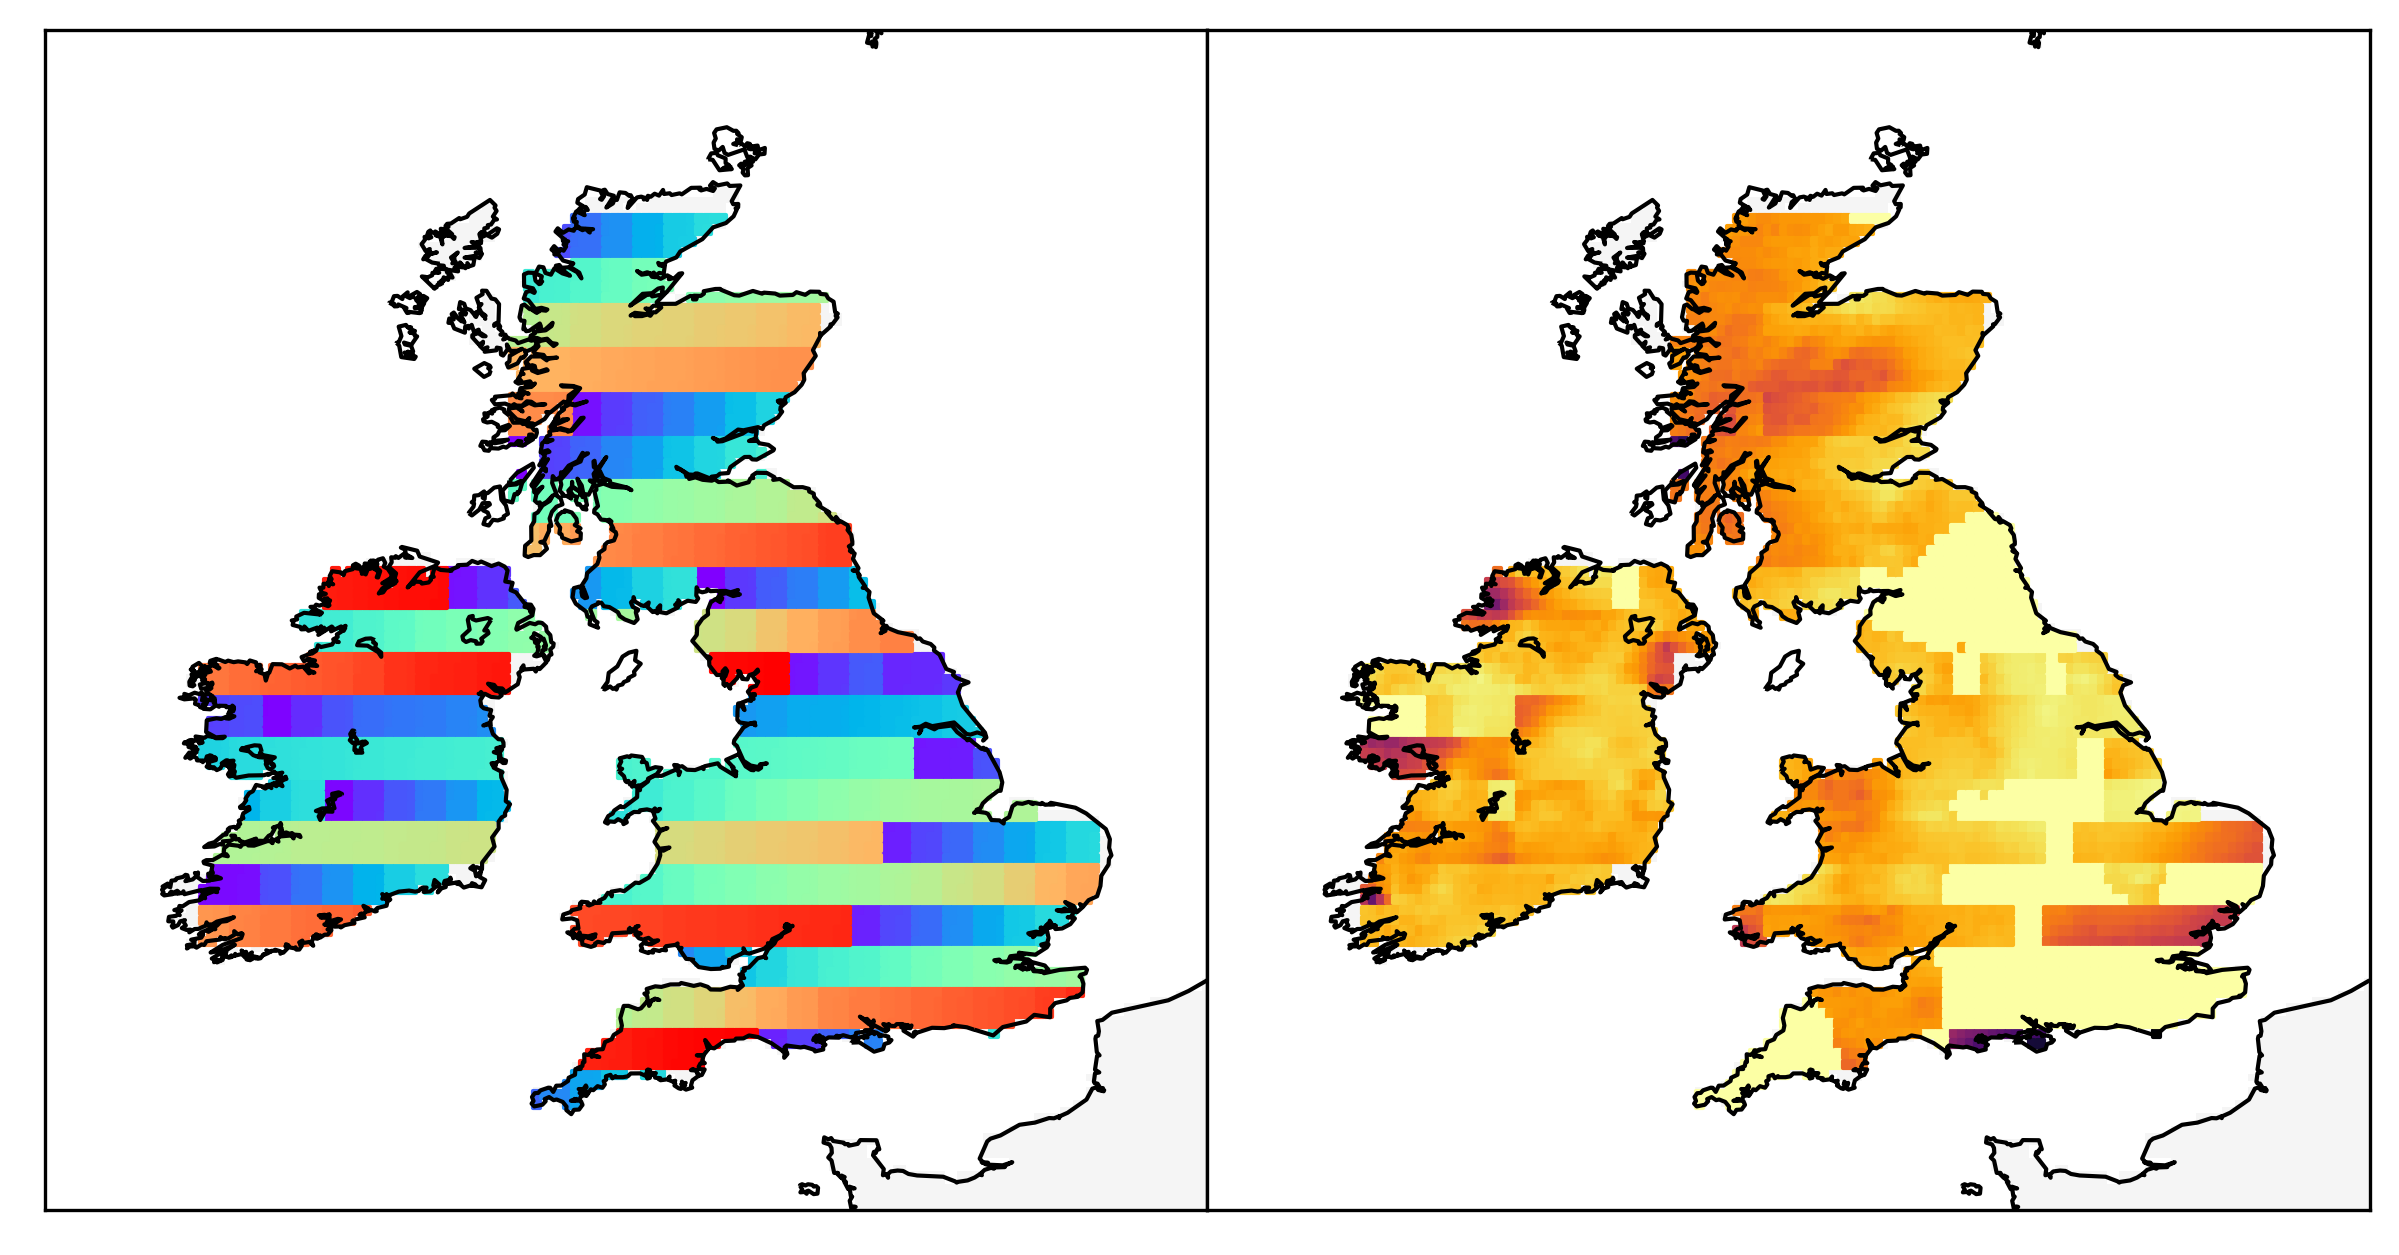

In [3]:
# plot locations plot vs observed rain for range of days
for k in [211]:
    print(k)
    fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True,sharey=True,figsize=(10,7))
    length = len(GNM_landonly)

    for day,ax in tqdm(enumerate(axes.flat)):
        map_ax = Basemap(projection='mill',
                resolution='i',llcrnrlat = 49,
                llcrnrlon = -12,
                urcrnrlat = 60,
                urcrnrlon = 3,
                ax=ax)
        fig.set_dpi(300)
        map_ax.drawcoastlines()
        map_ax.drawlsmask(land_color='whitesmoke')
        ax.set_aspect('equal')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplots_adjust(wspace=0, hspace=0)
        if day==0:
            ax.scatter(x=[m_loc_4087[i][1]for i in range(length)],y=[m_loc_4087[i][0] for i in range(length)],c=[i for i in range(len(GNM_landonly))][:length],cmap='rainbow',s=3,marker='s')
        else:
            ax.scatter(x=[m_loc_4087[i][1] for i in range(length)],y=[m_loc_4087[i][0]for i in range(length)],c=np.array([GNM_landonly[i][3][k] for i in range(length)]),cmap='inferno_r',s=3,marker='s')
    plt.show()

### Simulating

Run this block to simulate. Change values at the top for day, samples, etc... Takes ~40s for all locations

In [155]:
# Run this block to simulate. Change values at the top for day, samples, etc... Takes ~1:30m for all locations.

sim_day = 0
sim_locations = range(4088)
kernel_type = 'Matern'
theta_values = [10,10] # MLE gave [4.01,3.08]
nb_samples = 10

#################################################################### Do not touch the rest ####################################################################

# Utility function
def g_Finv(day_id,loc_id,u): # take u to a value of rain according to the gamma density for that day and location
    if 1-GNM_landonly[loc_id][4][day_id]>=u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=GNM_landonly[loc_id][1][day_id]*GNM_landonly[loc_id][0][day_id],a=1/GNM_landonly[loc_id][1][day_id]).ppf((u-1+GNM_landonly[loc_id][4][day_id])/GNM_landonly[loc_id][4][day_id])

# Define truncation pi on normal scale := di. This is done for the whole dataset, no need to touch.
truncation_di = [[GNM_landonly[loc][4][day] for loc in range(4087)] for day in range(2002)] # di[day][loc]
truncation_di = scs.norm.ppf(np.array(truncation_di))

# Simulating Draws. Dependent on given day and locations.
simulated_us = truncgauss(dist_mat[:max(sim_locations),:max(sim_locations)]).sim(theta=theta_values,inv_us=truncation_di,draws=nb_samples,day_idx=sim_day,kernel=kernel_type)
simulated_rain = [[g_Finv(0,loc,simulated_us[draw][loc]) for loc in range(len(simulated_us[0]))] for draw in range(len(simulated_us))]

print('Simulations done!')

Simulations done!


### Plotting samples

No need to touch anything, just run cells.

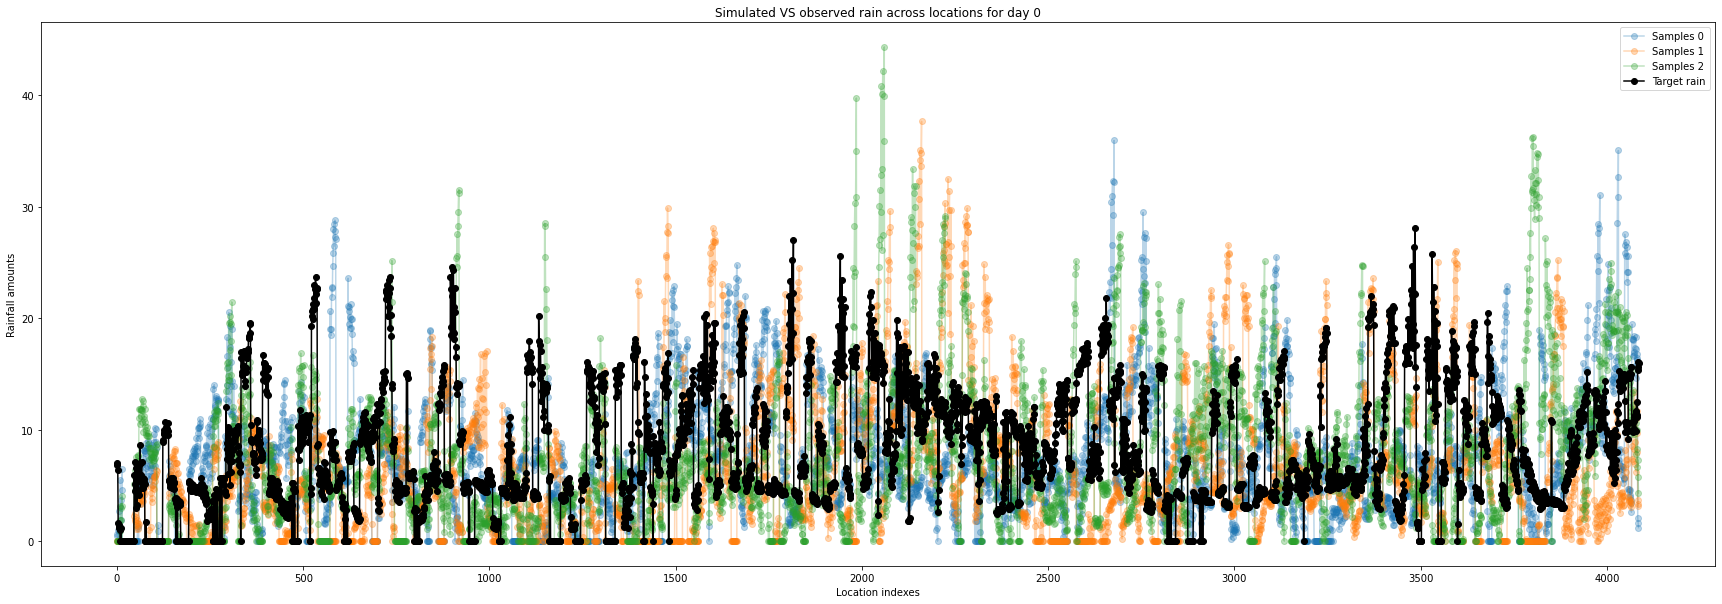

In [165]:
# Samples vs target rain with locations on the x-axis and rain on the y-axis.
fig = plt.gcf()
fig.set_size_inches(30, 10)
dpi=300
for k in range(len(simulated_rain)):
    plt.plot(simulated_rain[k],'-o',alpha=0.3,label='Samples '+str(k))
plt.plot([GNM_landonly[loc][3][sim_day] for loc in sim_locations ],'-o',color='black',label='Target rain')

plt.xlabel('Location indexes')
plt.ylabel('Rainfall amounts')
plt.title('Simulated VS observed rain across locations for day '+str(sim_day))
plt.legend(loc='upper right')
plt.show()

4it [00:07,  1.76s/it]


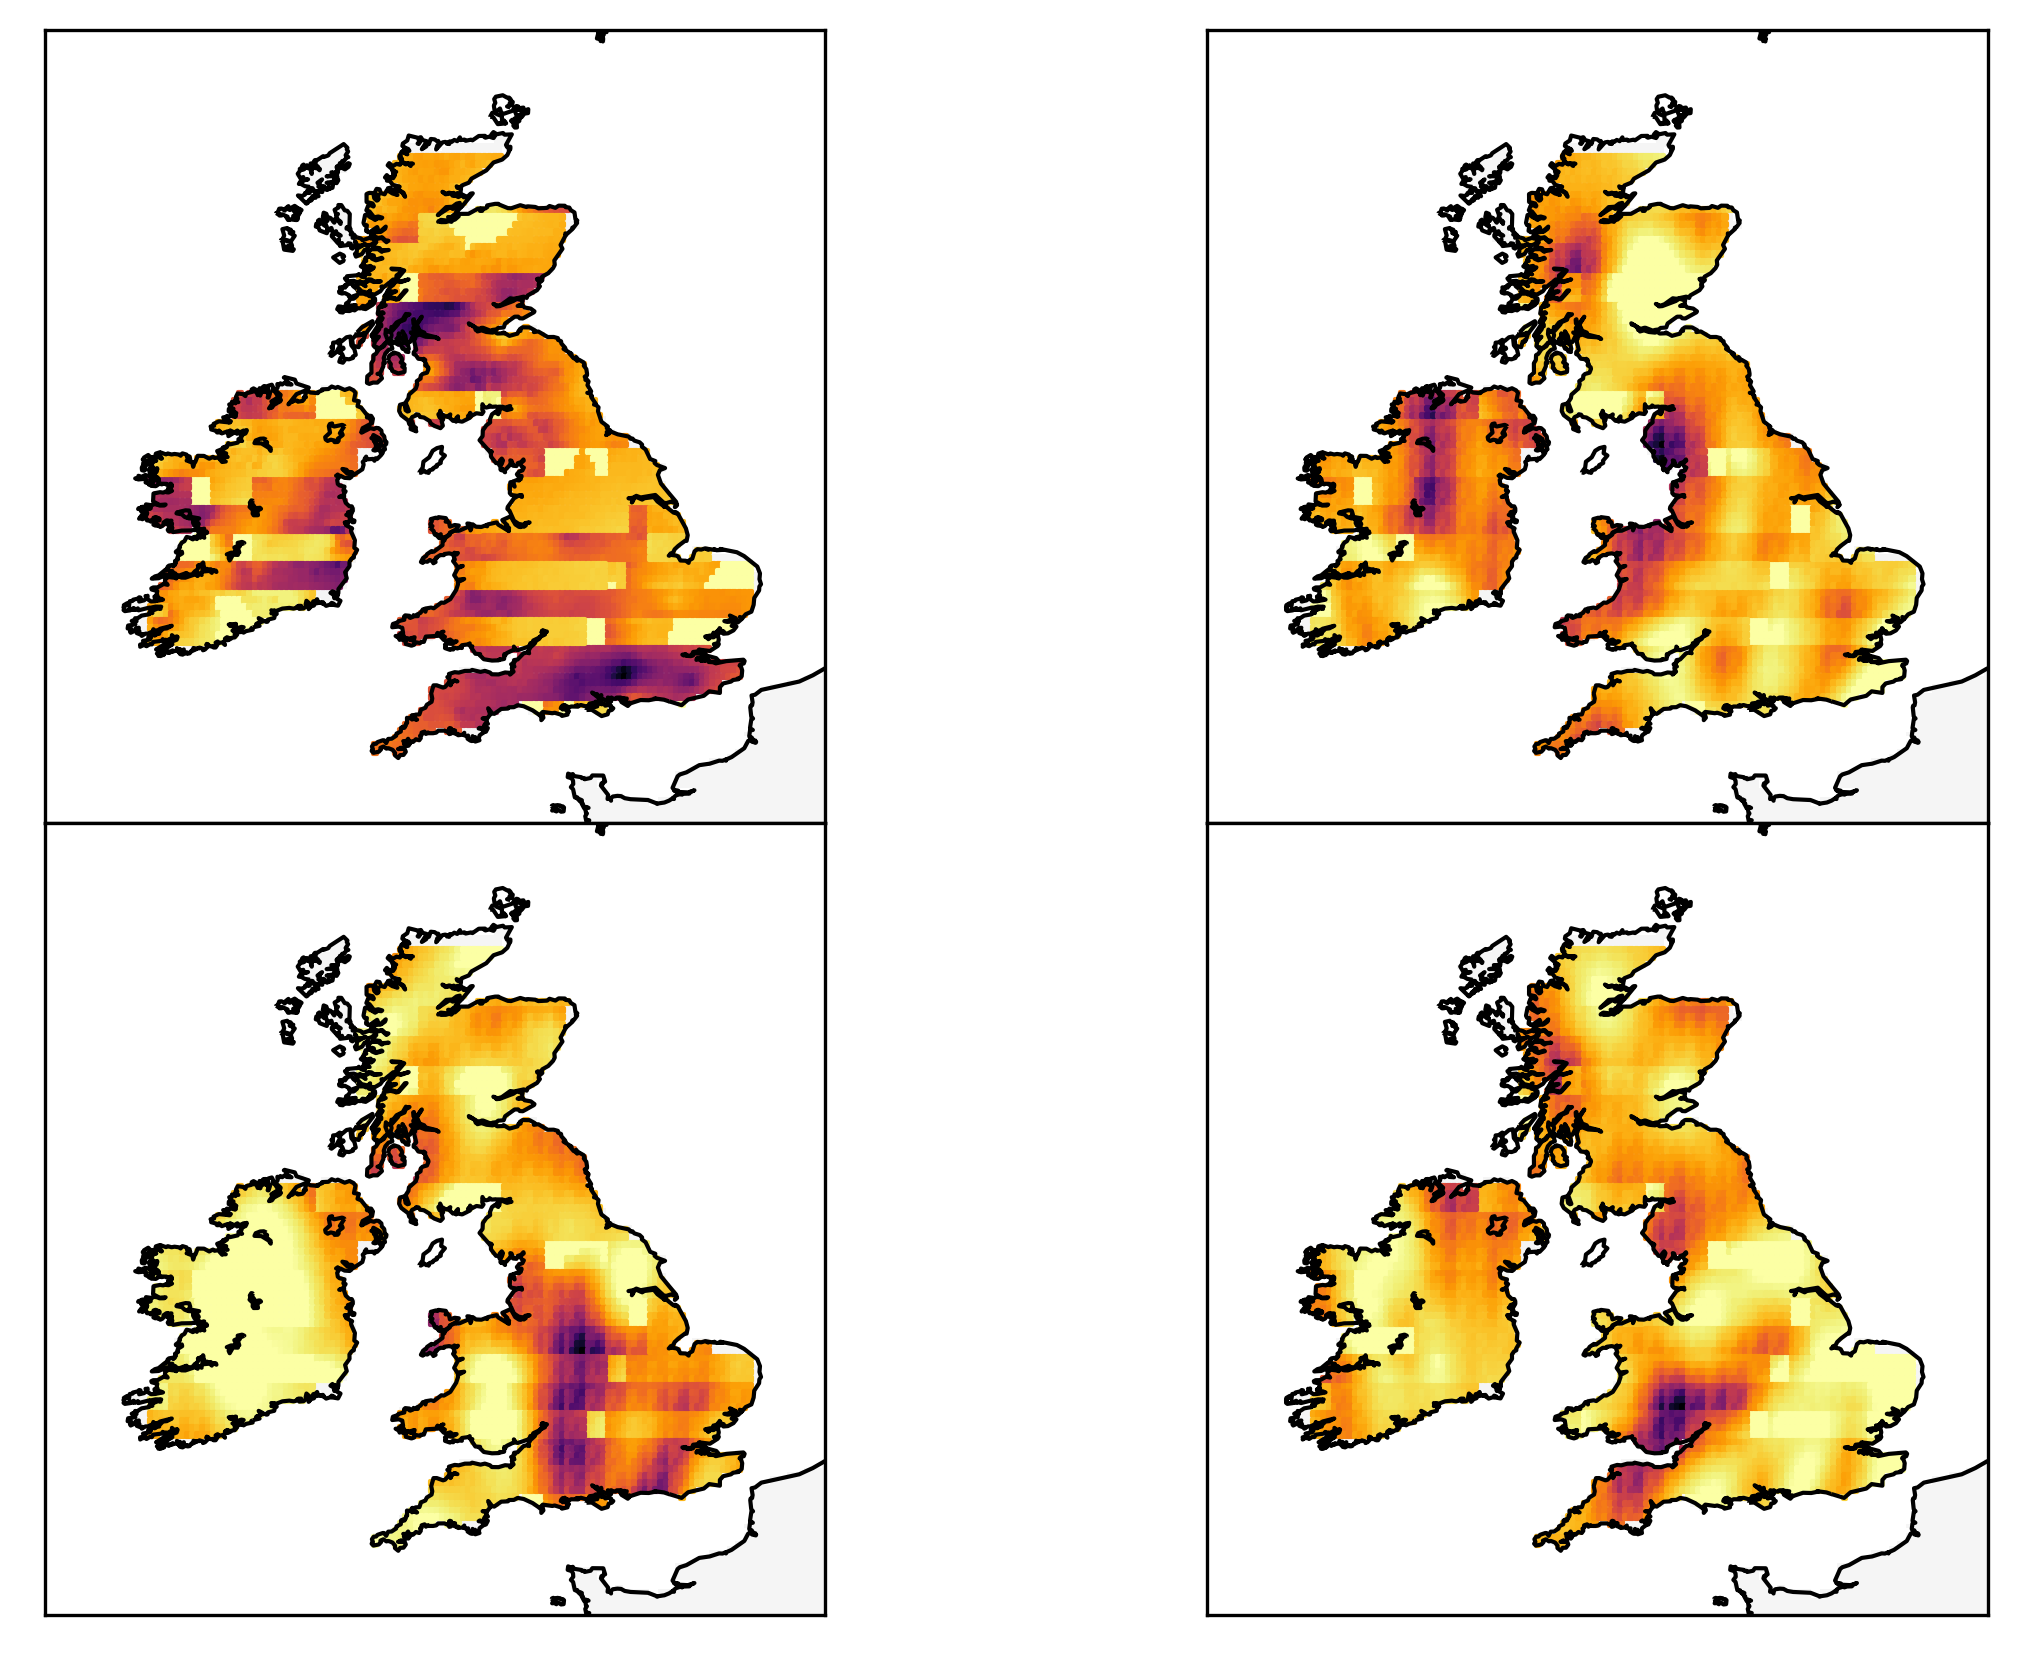

In [166]:
# Target vs samples on map for given day
fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True,sharey=True,figsize=(10,7))
length = max(sim_locations)
for day,ax in tqdm(enumerate(axes.flat)):
    map_ax = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3,
            ax=ax)
    fig.set_dpi(300)
    map_ax.drawcoastlines()
    map_ax.drawlsmask(land_color='whitesmoke')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    if day==0:
        ax.scatter(x=[m_loc_4087[i][1]for i in range(length)],y=[m_loc_4087[i][0] for i in range(length)],c=[GNM_landonly[loc][3][sim_day] for loc in range(length)],cmap='inferno_r',s=0.8,marker='s')
    else:
        #max_rain = max([GNM_landonly[loc][3][sim_day] for loc in range(length)])
        #ax.scatter(x=[m_loc_4087[i][1] for i in range(length)],y=[m_loc_4087[i][0]for i in range(length)],c=np.minimum(np.array(simulated_rain[day-1]),np.array([max_rain for l in range(len(simulated_rain[0]))])),cmap='viridis',s=0.8,marker='s')
        ax.scatter(x=[m_loc_4087[i][1] for i in range(length)],y=[m_loc_4087[i][0]for i in range(length)],c=np.array(simulated_rain[day-1]),cmap='inferno_r',s=0.8,marker='s')
plt.show()

### Diagnostics

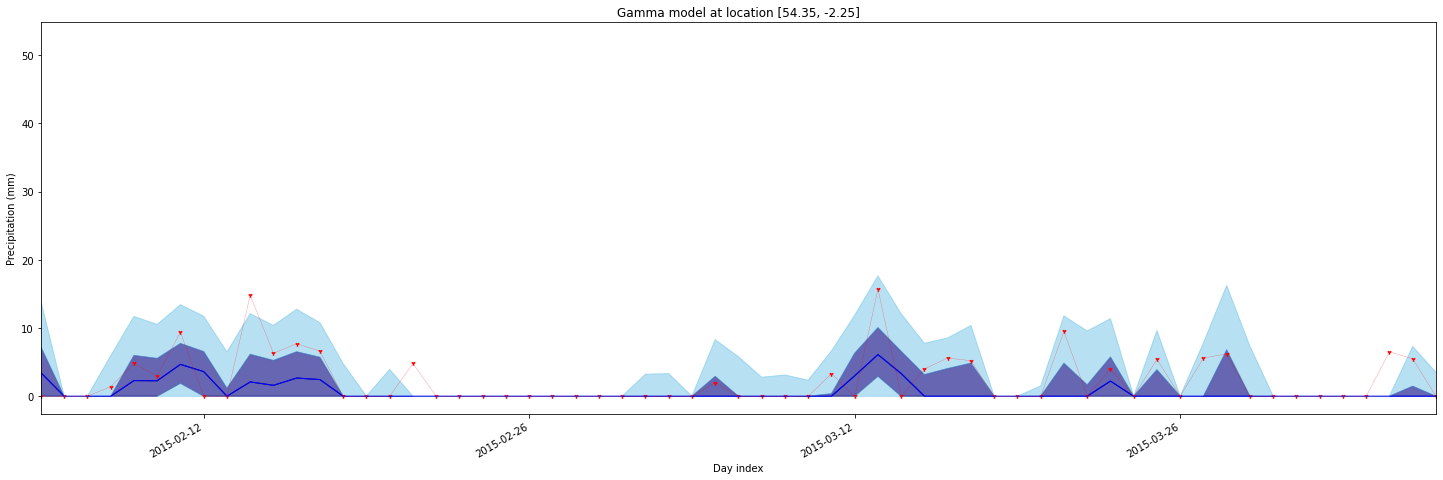

In [2]:
# Draw time-series plot with quantiles for predicted vs trget rain at a given location. ~3s 
# Just change values at the top.

ts_plot_location = 111
ts_plot_left_lim,ts_plot_right_lim = 400,460

#################################################################### Do not touch the rest ####################################################################
import matplotlib.dates as mdates

# mean and 68, 95 percentiles 
g_median = []
g_q25 = []
g_q75 = []
g_q68 = []
g_q95 = []
g_q32 = []
g_q05 = []

#GNM_landonly[location][param][day]
## 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

#gamma_outputs [place][parameter][day][row][column]
# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.

for m,d,i in zip([GNM_landonly[ts_plot_location][0][i] for i in range(2002)],[GNM_landonly[ts_plot_location][1][i] for i in range(2002)],range(2002)) :
    rv = scs.gamma(scale=m*d,a=1/d)  
      
    g_median.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.5)/GNM_landonly[ts_plot_location][4][i]))
    g_q25.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.25)/GNM_landonly[ts_plot_location][4][i]))
    g_q75.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.75)/GNM_landonly[ts_plot_location][4][i]))
    g_q68.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.68)/GNM_landonly[ts_plot_location][4][i]))
    g_q95.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.95)/GNM_landonly[ts_plot_location][4][i]))
    g_q32.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.32)/GNM_landonly[ts_plot_location][4][i]))
    g_q05.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.05)/GNM_landonly[ts_plot_location][4][i]))

for q in [g_median,g_q25,g_q05,g_q32,g_q68,g_q75,g_q95]:
    for i in range(len(q)):
        if math.isnan(q[i]):
            q[i]=0
            
plt.figure(figsize=(25, 8))
plt.plot(day_dates,g_q05,color='skyblue',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_q25,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_median,color='blue',linewidth=1,alpha=1)
plt.plot(day_dates,g_q75,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_q95,color='skyblue',linewidth=0.6,alpha=0.3)
plt.fill_between(day_dates, g_median, g_q75, where=([g_median[k] < g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_median, g_q25, where=([g_median[k] > g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_q95, g_q75, where=([g_q95[k] > g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_q05, g_q25, where=([g_q05[k] < g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.scatter(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(2002)],color='r',marker='1',s=20)
plt.plot(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(2002)],color='r',alpha=0.6,linewidth=0.3)
plt.xlim((day_dates[ts_plot_left_lim],day_dates[ts_plot_right_lim]))
plt.title('Gamma model at location '+str(GNM_landonly[ts_plot_location][5]))
plt.xlabel('Day index')
plt.ylabel('Precipitation (mm)')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gcf().autofmt_xdate()
plt.show()

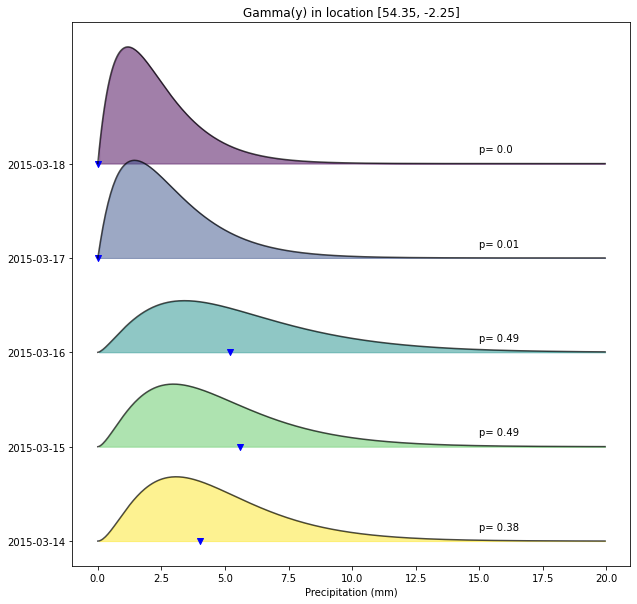

In [4]:
# Densities plots
# Just change values at the top.

density_plot_location = 111
density_plot_start,density_plot_end = 437,442

#################################################################### Do not touch the rest ####################################################################
import matplotlib

x=[i/20 for i in range(400)]
plt.figure(figsize=(10,(density_plot_end-density_plot_start)*2))
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(range(density_plot_end,density_plot_start,-1))))
for idx,col in zip(range(density_plot_end,density_plot_start,-1),colors):
    rv=scs.gamma(scale=[GNM_landonly[density_plot_location][1][i] for i in range(2002)][idx]*[GNM_landonly[density_plot_location][0][i] for i in range(2002)][idx],a=1/[GNM_landonly[density_plot_location][1][i] for i in range(2002)][idx])
    level=(-0.3+(idx-density_plot_start)*0.25)
    plt.plot(x,level+rv.pdf(x),color='black',alpha=0.7)
    plt.fill_between(x,y1=level+rv.pdf(x),y2=level,where=([level+rv.pdf(x_)>level for x_ in x]),color=col,alpha=0.5)
    plt.text(15,level+0.03,'p= '+str(round([GNM_landonly[density_plot_location][4][i] for i in range(2002)][idx],2)))
    plt.scatter([GNM_landonly[density_plot_location][3][i] for i in range(2002)][idx],level,marker='v',color='b')
plt.xlabel('Precipitation (mm)')
plt.title('Gamma(y) in location '+str(GNM_landonly[density_plot_location][5]))
plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],[date.astype('datetime64[D]') for date in day_dates[density_plot_start:density_plot_end][::-1]])
#plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],[k for k in range([density_plot_start:density_plot_end]])
plt.show()

In [190]:
# Median rain forecasts for all days and locations
#GNM_landonly[location][param][day]

'''
# Used to get the vectors for all locations and all times, not needed after that.

g_median_all=[]

for loc in tqdm(range(len(GNM_landonly))):
    for day in range(len(GNM_landonly[0][1])):
        m,d = GNM_landonly[loc][0][day] , GNM_landonly[loc][1][day]
        rv = scs.gamma(scale=m*d,a=1/d)  
        g_median_all.append(rv.ppf((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day]))

with open('g_median_all.txt','wb') as f:
    pickle.dump(g_median_all,f)
'''

with open('g_median_all.txt','rb') as f:
    g_median_all = pickle.load(f)
g_median_all = np.nan_to_num(g_median_all,nan=0)

In [156]:
#This computes the spread and skill for all locations and days. Takes ~7+ hours for whole dataset (given 10 samples are used for spread, 14s / day)

RMS_spread = [] # should get 2002 entries, each being the average RMS across all locations and draws, for that day.
RMS_skill = [] # should get 2002 entries, each being the average RMS across all locations, for that day.

for day in tqdm(range(100)):
    # The expression used below is the RMS spread for one day: a single number, the average across all locations and all draws.
    RMS_spread.append(
        np.mean( # average over samples and locations 
            [ # get m entries, one per sample 
                np.power( # square
                    np.subtract( # difference
                        [g_Finv(day,loc,simulated_us[draw][loc]) for loc in range(len(simulated_us[0]))] # sampled u transformed to rainfall, for given day over all locs
                        ,np.transpose(np.array(g_median_all).reshape((4087,2002)))[day,:])  # median for given day across all locs
                        ,2) #square
                        for draw in range(len(simulated_us))] 
                        ))
    
    # The expressoin below is the RMS skill for one day: a single number giving the average across all locations of the squared difference of median forecast and target
    RMS_skill.append(
        np.mean( # average over locations
            np.power( # square
                np.subtract( # difference
                    np.transpose(np.array(g_median_all).reshape((4087,2002)))[day,:] # median for that day across all locations
                    ,[GNM_landonly[loc][3][day] for loc in range(4087)] ) # target rain for that day across all locations
                    ,2) # square
                    ))
                

100%|██████████| 100/100 [23:56<00:00, 14.36s/it]


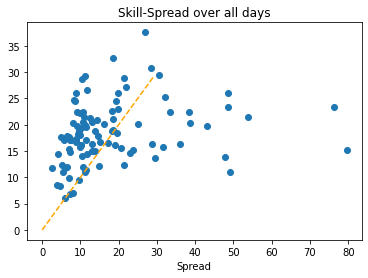

In [182]:
# Skill-Spread over all days
plt.scatter(RMS_skill,RMS_spread)
plt.plot(range(30),range(30),color='orange',linestyle='--')
plt.xlabel('Skill')
plt.xlabel('Spread')
plt.title('Skill-Spread over all days')
plt.show()

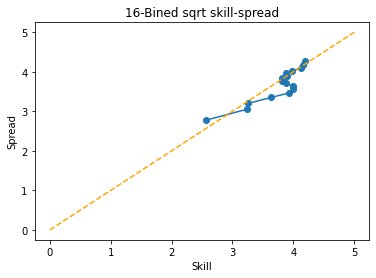

Text(0.5, 1.0, '16-Bined skill-spread')

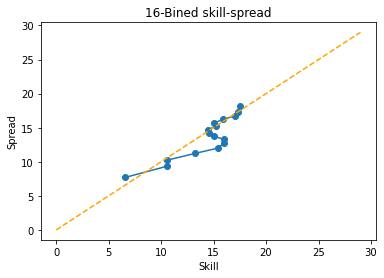

In [181]:
# 16-Bined skill-spread - Need to draw samples of u first. 
# They are then used for each day.
binned_skill = [math.sqrt(np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16,method='lower')])) for q in range(1,17)]
binned_spread = [math.sqrt(np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16,method='lower')])) for q in range(1,17)]

plt.plot(binned_skill,binned_spread,'-o')
plt.plot(range(6),range(6),color='orange',linestyle='--')
plt.xlabel('Skill')
plt.ylabel('Spread')
plt.title('16-Bined sqrt skill-spread')
#plt.xlim(10,25)
#plt.ylim(5,20)
plt.show()
binned_skill = [np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16,method='lower')]) for q in range(1,17)]
binned_spread = [np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16,method='lower')]) for q in range(1,17)]

plt.plot(binned_skill,binned_spread,'-o')
plt.plot(range(30),range(30),color='orange',linestyle='--')
plt.xlabel('Skill')
plt.ylabel('Spread')
plt.title('16-Bined skill-spread')


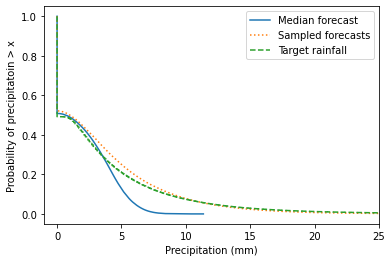

In [294]:
# P(rain>x) ~1m15 now. depending on samples and days used. all data an 10 samples->10h 
from statsmodels.distributions.empirical_distribution import ECDF
# transform us to rainfall over set of days and all locations
sampled_rain_flatten_all = np.array([np.array([np.array([g_Finv(day,loc,simulated_us[draw][loc]) for loc in range(4087)]) for day in np.random.choice(range(2002),13)]) for draw in range(4)]).flatten() # 2s per day * samples * days

# get empirical cdfs for median, sampled and target rain.
gamma_ecdf = ECDF(g_median_all)
target_ecdf = ECDF(np.array([np.array([GNM_landonly[loc][3][day] for loc in range(4087)]) for day in range(2002)]).flatten())
gamma_sampled_ecdf = ECDF(sampled_rain_flatten_all)
plt.plot(gamma_ecdf.x,1-gamma_ecdf.y,label='Median forecast')
plt.plot(gamma_sampled_ecdf.x,1-gamma_sampled_ecdf.y,linestyle='dotted',label='Sampled forecasts')
plt.plot(target_ecdf.x,1-target_ecdf.y,linestyle='--',label='Target rainfall')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Probability of precipitatoin > x')
plt.xlim(-1,25)
plt.legend()

In [335]:
# RMSB and MAB metrics across all days and locations ~1.2s
all_target_rain = np.array([np.array([GNM_landonly[loc][3][day]for day in range(2002)])for loc in range(4087)]).flatten().reshape(4087,2002) # [loc,day]
RMSB = math.sqrt(np.mean(np.power(np.subtract(all_target_rain,np.array(g_median_all).reshape((4087,2002))),2)))
MAB = np.mean(np.abs(all_target_rain-np.array(g_median_all).reshape((4087,2002))))
print('MAB = '+str(MAB)+', RMSB = '+str(RMSB))

MAB = 2.1647477859942126, RMSB = 4.111612000753093


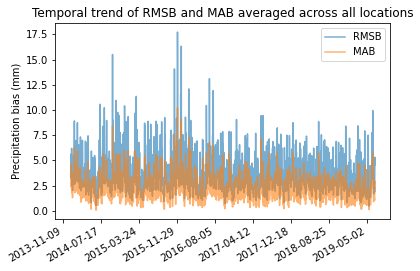

In [386]:
# Plot RMSB and MAB across time, averaged over all locations. 
import matplotlib.dates as mdates

RMSB_matrix = np.power(np.subtract(all_target_rain,np.array(g_median_all).reshape((4087,2002))),2)
MAB_matrix = np.abs(all_target_rain-np.array(g_median_all).reshape((4087,2002)))
RMSB_ts = [math.sqrt(np.mean(RMSB_matrix[:,day])) for day in range(2002)]
MAB_ts = [np.mean(MAB_matrix[:,day]) for day in range(2002)]
plt.plot(day_dates,RMSB_ts,alpha=0.6,label='RMSB')
plt.plot(day_dates,MAB_ts,alpha=0.6,label='MAB')
plt.legend()
plt.title('Temporal trend of RMSB and MAB averaged across all locations')
plt.ylabel('Precipitation bias (mm)')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round(2002/8)))
plt.gcf().autofmt_xdate()
plt.show()

### Notes

Latitude and longitude of locations we predict for and use are increments of 0.1 degrees, with 5 as second decimal values (0.05,0.15,0.25,...) .
